In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph
from einops import rearrange
from tqdm import tqdm
import torch.nn.functional  as Fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from io import BytesIO
from IPython.display import Image as IPyImage, display
from PIL import Image
import matplotlib.pyplot as plt
import os
from piq import ssim
import gc


import wandb
wandb.login()

In [ ]:
wandb.init(
    project="Transformer-Decoder",  
    name="experiment-2",    
    # id="uqcub7jq",  
    # resume="allow",
    # config={                       
    #     "epochs": 1000,
    #     "batch_size": 64,
    # }
)

Implementation
https://www.youtube.com/watch?v=1mi2MSvigcc&t=18s

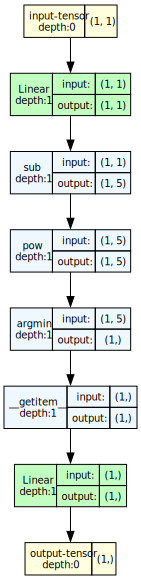

In [2]:
class VQVAEQuantizeWithoutDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithoutDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

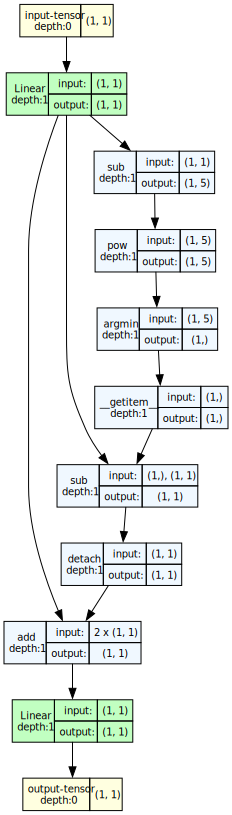

In [3]:
class VQVAEQuantizeWithDerivative(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.codebook = nn.Parameter(torch.tensor([-5., -9., 0., 6., 9.]))
        self.decoder = nn.Linear(1, 1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        l2_difference = (encoder_out - self.codebook) ** 2
        nearest_index = torch.argmin(l2_difference, dim = -1)
        # print(nearest_index)
        decoder_input = self.codebook[nearest_index]
        # print(decoder_input)
        decoder_input = encoder_out + (decoder_input - encoder_out).detach()
        decoder_out = self.decoder(decoder_input)
        return decoder_out

q = VQVAEQuantizeWithDerivative()
test = torch.ones(1).unsqueeze(0)
out = q(test)
# print(out)
out.backward()
model_graph = draw_graph(q, input_size = (1, 1))
model_graph.visual_graph

In [4]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps
        self.dead_codeBook_threshold = codeBookDim * 0.6

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        log_encoding_sum = -torch.sum(avg_probs * torch.log(avg_probs + 1e-10))
        perplexity = torch.exp(log_encoding_sum)

        entropy = log_encoding_sum
        normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device))
        diversity_loss = 1.0 - normalized_entropy

        return quantized, encoding_indices, perplexity, diversity_loss
        
        
vq = VectorQuantizeImage(codeBookDim=64,embeddingDim=32)
rand = torch.randn(1024,32)
vq(rand)

(tensor([[ 0.0076, -0.1164, -0.1279,  ...,  0.2217, -0.1865, -0.1482],
         [-0.1268, -0.2408, -0.2086,  ..., -0.1632, -0.2268, -0.0805],
         [-0.0532, -0.0231,  0.0961,  ...,  0.1483, -0.0497, -0.2178],
         ...,
         [-0.1268, -0.2408, -0.2086,  ..., -0.1632, -0.2268, -0.0805],
         [ 0.2493, -0.1808, -0.0879,  ..., -0.1583, -0.1397,  0.1630],
         [-0.0361, -0.2480, -0.2384,  ...,  0.1310, -0.2266,  0.1190]],
        grad_fn=<MmBackward0>),
 tensor([ 9, 55, 41,  ..., 55, 35, 59]),
 tensor(59.3482),
 tensor(0.0181))

In [5]:
class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 32, codeBookdim = 128, embedDim = 128):
        super().__init__()
        self.inChannels = inChannels
        self.hiddenDim = hiddenDim
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(inChannels, hiddenDim, 4, 2, 1), 
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, embedDim, 1),
        )

        self.vector_quantize = VectorQuantizeImage(codeBookDim=codeBookdim,embeddingDim=embedDim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(2 * hiddenDim, 2 * hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(2 * hiddenDim, hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, hiddenDim, 3, 1, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hiddenDim, inChannels, 1),
            nn.Sigmoid()
        )

    def encodeImage(self, x, noise_std = 0.15):
        if self.training:
            encodedOut = self.encoder(x)
            encodedOut = encodedOut + torch.randn_like(encodedOut) * noise_std
        else:
            encodedOut = self.encoder(x)

        return encodedOut

    def decodeImage(self, quantized_vector):
        decodedOut = self.decoder(quantized_vector)
        return decodedOut

    def forward(self, x):
        batch_size, inChannels, height, width = x.shape
        encodedOut = self.encodeImage(x)
        batch_size, encoded_channel, encoded_height, encoded_width = encodedOut.shape
        
        # print(f"Encoded Shape: {encodedOut.shape}")

        
        vectorize_input = rearrange(encodedOut, 'b c h w -> (b h w) c')
        quantized_vectors, encoding_indices, perplexity, diversity_loss  = self.vector_quantize(vectorize_input)
        codebook_loss = Fn.mse_loss(vectorize_input.detach(), quantized_vectors)
        commitment_loss = Fn.mse_loss(vectorize_input, quantized_vectors.detach())

        quantized_vectors = vectorize_input + (quantized_vectors - vectorize_input).detach()
        # print(f"CodeBook Loss: {codebook_loss} , Commitment Loss: {commitment_loss}")
        # print(f"Quantized SHape: {quantized_vectors.shape}")

        decoder_input = rearrange(quantized_vectors, '(b h w) d -> b d h w', d = encoded_channel, h = encoded_height, w = encoded_width)
        # print(f"Decoded Input SHape: {decoder_input.shape}")
        decodedOut = self.decodeImage(decoder_input)

        # print(f"Decoded SHape: {decodedOut.shape}")
        
        return decoder_input, decodedOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss

VQ = VecQVAE(inChannels = 1, hiddenDim = 256, codeBookdim = 128, embedDim = 64)
test = torch.randn(32, 1, 64, 64)
quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = VQ(test)
quantized_latents.shape, decoderOut.shape, codebook_loss, commitment_loss, encoding_indices.shape, perplexity, diversity_loss

(torch.Size([32, 64, 16, 16]),
 torch.Size([32, 1, 64, 64]),
 tensor(0.1828, grad_fn=<MseLossBackward0>),
 tensor(0.1828, grad_fn=<MseLossBackward0>),
 torch.Size([8192]),
 tensor(37.0703),
 tensor(0.2554))

In [6]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data)
data = data.unsqueeze(2)
print(data.shape)
flattened_frame_dataset = data.reshape(-1, 1, 64, 64)
print(flattened_frame_dataset.shape)
flattened_frame_dataset[0].shape

(20, 10000, 64, 64)
torch.Size([10000, 20, 1, 64, 64])
torch.Size([200000, 1, 64, 64])


torch.Size([1, 64, 64])

In [7]:
flattened_frame_dataset = data.reshape(-1, 1, 64, 64)
print(flattened_frame_dataset.shape)
flattened_frame_dataset[0].shape

torch.Size([200000, 1, 64, 64])


torch.Size([1, 64, 64])

In [8]:
class FrameDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.data = self.data/255.0
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.data[index]
    

test = torch.randn(1000, 1, 64, 64)
out = FrameDataset(test)
print(out.__len__())
x, y = out.__getitem__(0)
x.shape, y.shape


1000


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

In [9]:
codeBookdim = 128
embedDim = 64
hiddenDim = 256
inChannels = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torchDataset = FrameDataset(flattened_frame_dataset)
dataloader = DataLoader(torchDataset, batch_size=64, shuffle = True)
modelA = VecQVAE(inChannels = inChannels, hiddenDim = hiddenDim, codeBookdim = codeBookdim, embedDim = embedDim).to(device)
lossFn = nn.MSELoss()
optimizerA = torch.optim.Adam([
                    {'params': modelA.encoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.decoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.vector_quantize.parameters(), 'lr': 1e-4}
                ], weight_decay=1e-5)
schedulerA = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizerA, T_0=10, T_mult=2, eta_min=1e-6
            )

epochs = 1000

In [10]:
modelValA = torch.load("./model/VQVAE/vqvae.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

for each_epoch in range(epochs):
    modelA.train()
    reconstruct_loss = 0.0
    codeb_loss = 0.0
    commit_loss = 0.0
    vqvaeloss = 0.0
    diverse_loss = 0.0
    ssim_loss = 0.0
    
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    perplexities = []

    for X, Y in loop:
        X = X.to(device)
        Y = Y.to(device)
        # print(X.shape, Y.shape)
    #     break
    # break
        
        quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = modelA(X)

        ssim_score = ssim(Y, decoderOut, data_range=1.0)
        ssim_loss = 1.0 - ssim_score

        reconstruction_loss = torch.mean((Y - decoderOut)**2)
        
        loss = reconstruction_loss + codebook_loss + 0.2 * commitment_loss + 0.1 * diversity_loss + 0.1 * ssim_loss
        vqvaeloss += loss.item()

        
        reconstruct_loss += reconstruction_loss.item()
        diverse_loss += diversity_loss.item()
        codeb_loss += codebook_loss.item()
        commit_loss += commitment_loss.item()
        ssim_loss += ssim_loss.item()
        perplexities.append(perplexity)
        
        
        optimizerA.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelA.parameters(), max_norm=1.0)
        optimizerA.step()
        loop.set_postfix({"TotalL": f"{vqvaeloss}", "ReconsL": f"{reconstruct_loss}", "CodeL":f"{codeb_loss}",
                          "CommitL":f"{commitment_loss}", "Perplexity":f"{perplexity}", "Diversity Loss":f"{diverse_loss}", "SSIM Loss":f"{ssim_loss}"})
    #     break
    # break

    average_perplexity = sum(perplexities)/len(perplexities)
    vqvaeloss /= len(dataloader)   
    reconstruct_loss /= len(dataloader)   
    codeb_loss /= len(dataloader)   
    commit_loss /= len(dataloader)   
    diverse_loss /= len(dataloader)
    torch.save(modelA.state_dict(), "./model/VQVAE/vqvae.pt")
    wandb.log({
        "Epoch": each_epoch,
        "VQVAE LR": optimizerA.param_groups[0]['lr'],
        "VQVAE Loss": vqvaeloss,
        "Reconstruction Loss": reconstruct_loss,
        "Codebook Loss": codeb_loss,
        "Commitment Loss": commit_loss,
        "Diversity Loss": diverse_loss,
        "Perplexity": average_perplexity,
        "SSIM Loss":ssim_loss,
    })
    schedulerA.step()
 

0/1000:   0%|          | 1/3125 [00:06<5:57:20,  6.86s/it, TotalL=0.045000385493040085, ReconsL=0.0006636377656832337, CodeL=0.02427852153778076, CommitL=0.02427852153778076, Perplexity=62.87490463256836, Diversity Loss=0.14651250839233398, SSIM Loss=0.011025428771972656]


KeyboardInterrupt: 

In [10]:
modelValA = torch.load("./model/VQVAE/vqvae-5.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

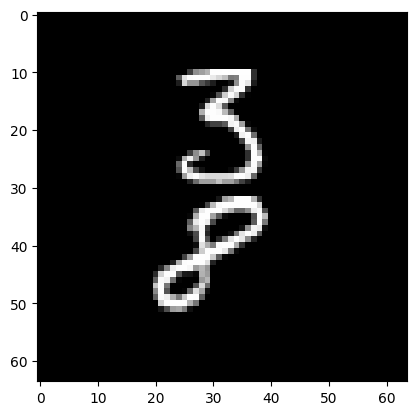

In [11]:
c = data[10][0].squeeze().numpy()
plt.imshow(c, cmap = 'gray')

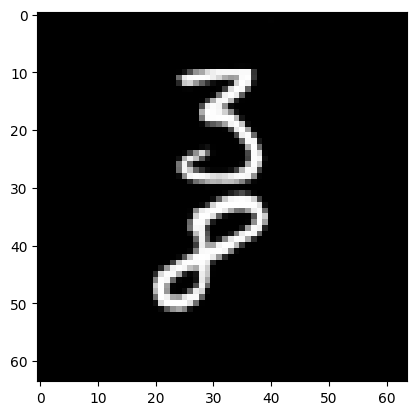

In [12]:
out = modelA.encodeImage(data[10][0].unsqueeze(0)/255.0)
decimg = modelA.decodeImage(out)
x = (decimg * 255.0).squeeze().squeeze().detach().numpy()
plt.imshow(x, cmap = 'gray')

In [13]:
def testImages(imagepath, model):
    img = Image.open(imagepath)
    img = img.convert("L")
    img = img.resize((64, 64))
    img_array = np.array(img)
    img_array = np.array(img).astype(np.float32)
    
    tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0)

    out_image, _, _, _, _, _, _ = model(tensor/255.0)
    out_image = model.decodeImage(out_image)
    out_image = out_image.squeeze()
    out_image = (out_image * 255).byte().cpu().numpy()

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(img_array, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Actual Image", fontsize=8)

    # Generated image
    axs[1].imshow(out_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Generated Image", fontsize=8)

    plt.tight_layout()
    plt.show()


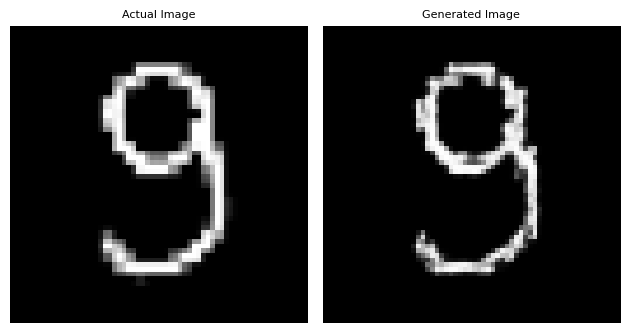

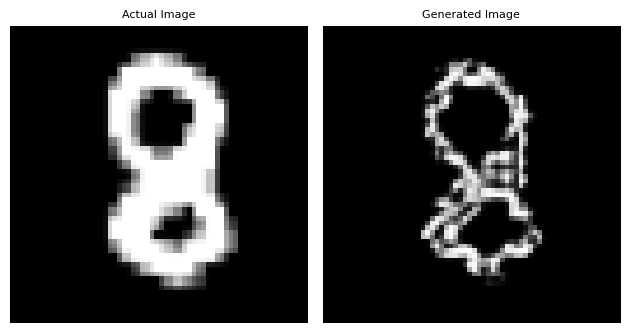

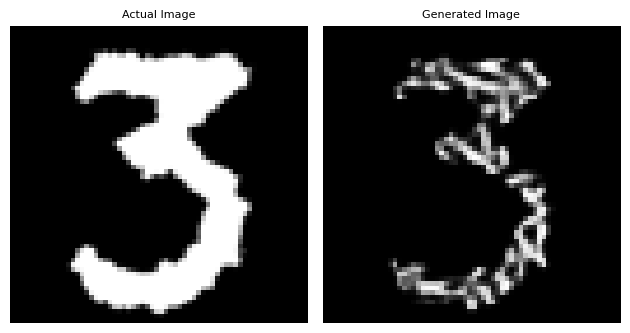

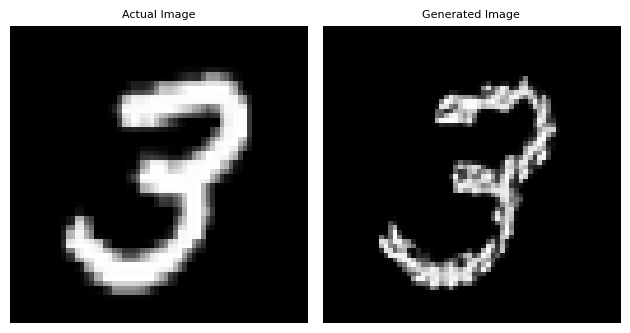

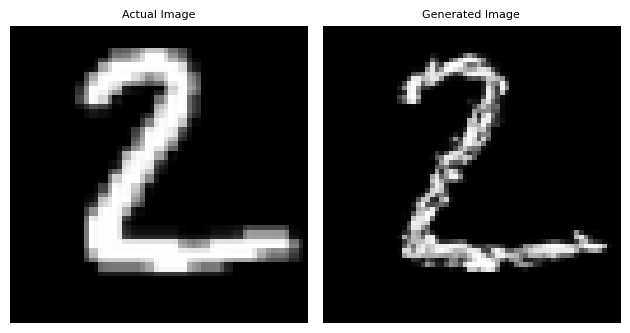

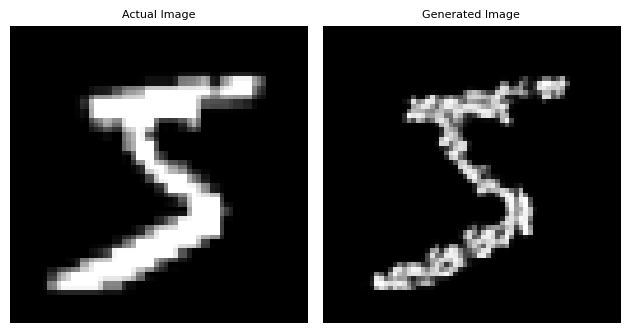

In [14]:
for i in os.listdir("data/testImages"):
    # print(i)
    testImages("data/testImages/"+i, modelA)

In [15]:
modelValA = torch.load("./model/VQVAE/vqvae-5.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

<All keys matched successfully>

In [16]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
print(data.shape)
data = np.transpose(data, (1, 0, 2, 3))
data = torch.from_numpy(data).to(dtype=torch.float32)
data = data.unsqueeze(2)
data.shape


(20, 10000, 64, 64)


torch.Size([10000, 20, 1, 64, 64])

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

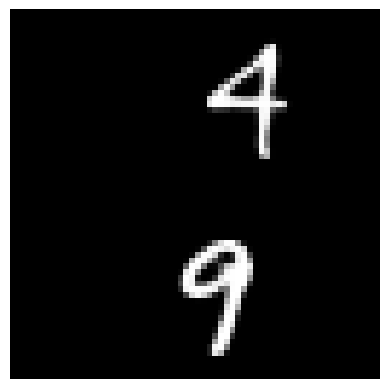

In [17]:
quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = modelA(data[50][0].unsqueeze(0)/255.0)

# B = encoding_indices.shape[0] // (16 * 16)
indices = encoding_indices.view(1, 16, 16)
embeddings = modelA.vector_quantize.codebook(indices)  
# print(embeddings.shape)
z_q = embeddings.permute(0, 3, 1, 2).contiguous()
with torch.no_grad():
    recon_image = modelA.decodeImage(z_q)

# recon_image.shape
x = (recon_image * 255.0).squeeze().squeeze().detach().numpy()
plt.imshow(x, cmap = 'gray')
plt.axis('off')

In [18]:
# input_seqs = []
# target_seqs = []
# for j in range(data.shape[0]):
#     for i in range(10):  
#         with torch.no_grad():
#             modelA.eval()            
#             input_seq = (data[j][i:i+10]).unsqueeze(1)   
#             target_seq = (data[j][i+1:i+11]).unsqueeze(1)
#     #         print(input_seq.shape, target_seq.shape)
#     #         break
#     # break
#             encodedInput = modelA.encodeImage(input_seq)  
#             encodedOutput = modelA.encodeImage(target_seq)  
#             input_seqs.append(encodedInput)
#             target_seqs.append(encodedOutput)

# input_seqs = np.array(input_seqs)
# target_seqs = np.array(target_seqs)

In [19]:
data.shape

torch.Size([10000, 20, 1, 64, 64])

In [20]:
class VideoSequenceData(Dataset):
    def __init__(self, data, modelA, input_length=10, cache_dir="./data/encodingIndices/"):
        super().__init__()
        self.data = data
        self.modelA = modelA.eval().to(device)
        self.input_length = input_length
        self.sequence_per_video = 20 - self.input_length
        self.total_samples = len(data) * self.sequence_per_video
        self.cache_dir = cache_dir
        
        os.makedirs(cache_dir, exist_ok=True)
        
        self.video_cache = {}
    
    def _get_cache_path(self, video_idx):
        return os.path.join(self.cache_dir, f"video_{video_idx}_indices.pt")
    
    def _compute_video_indices(self, video_idx):
        cache_path = self._get_cache_path(video_idx)
        
        if os.path.exists(cache_path):
            return torch.load(cache_path, map_location='cpu')
        
        video = self.data[video_idx]
        indices = []
        
        with torch.inference_mode():
            frames = video / 255.0
            frames = frames.to(device)
            
            for frame in frames:
                frame = frame.unsqueeze(0)
                _, _, _, _, encoding_indices, _, _ = self.modelA(frame)
                indices.append(encoding_indices.cpu()) 
        
        video_indices = torch.stack(indices)
        
        torch.save(video_indices, cache_path)
        
        return video_indices
    
    def __getitem__(self, idx):
        video_idx = idx // self.sequence_per_video
        start = idx % self.sequence_per_video
        end = start + self.input_length + 1
        
        if video_idx not in self.video_cache:
            self.video_cache[video_idx] = self._compute_video_indices(video_idx)
        
        codebook_indices = self.video_cache[video_idx][start:end]
        
        X = codebook_indices[:-1]
        Y = codebook_indices[1:]
        return X, Y
    
    def __len__(self):
        return self.total_samples
    
# val = VideoSequenceData(data, modelA)
# X, Y = val.__getitem__(20)
# print(X.shape, Y.shape)
# val.__len__()

In [21]:
class TransformerDecoderModel(nn.Module):
    def __init__(self, sequence_len, num_tokens, codebook_size, embedding_dim, num_layers, numHeads, feedForwardDim=1024, drop=0.1):
        super().__init__()
        self.sequence_len = sequence_len
        self.num_tokens = num_tokens
        self.codebook_size = codebook_size
        self.total_tokens = sequence_len * num_tokens
        
        self.token_embedding = nn.Embedding(codebook_size, embedding_dim)        
        self.position_embedding = nn.Embedding(self.total_tokens, embedding_dim)
        
        self.decoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=numHeads, 
            dim_feedforward=feedForwardDim, 
            dropout=drop, 
            batch_first=True,
            norm_first=True,
        )
        self.decoder = nn.TransformerEncoder(self.decoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(drop)
        self.norm = nn.LayerNorm(embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, codebook_size)

    def forward(self, x):

        batch_size, seq_len, tokens = x.shape
        x_flat = rearrange(x, 'b s t -> b (s t)')
        # print(f"Flattened Shape: {x_flat.shape}")
        token_embeds = self.token_embedding(x_flat)
        
        positions = torch.arange(0, self.total_tokens, device=x.device).unsqueeze(0)
        pos_embeds = self.position_embedding(positions)
        
        decoder_input = self.dropout(token_embeds + pos_embeds)
        # print(f"Decoder Input: {decoder_input.shape}")
        
        seq_len = self.total_tokens
        causal_mask = torch.triu(
            torch.full((seq_len, seq_len), float('-inf')), 
            diagonal=1
        ).to(x.device)
        
        decoder_out = self.decoder(decoder_input, mask=causal_mask)
        decoder_out = self.norm(decoder_out)
        logits = self.output_layer(decoder_out)
        return logits

tModel = TransformerDecoderModel(
    sequence_len=10,
    num_tokens=256,
    codebook_size=128,
    embedding_dim=512,
    num_layers=6,
    numHeads=8
)

test_indices = torch.randint(0, 128, (1, 10, 256))
logits = tModel(test_indices)
print(logits.shape)

/Users/ishananand/miniforge3/envs/pytorch_env/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([1, 2560, 128])


In [22]:
batch_size = 4
num_tokens=256
sequence_len = 10
learning_rate = 3e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
numHeads = 8
dropout = 0.1
num_layers = 4
embed_dim = 512

torchDataset = VideoSequenceData(data, modelA)
dataloader = DataLoader(torchDataset, batch_size=batch_size, shuffle = True, num_workers=8, persistent_workers=True)
modelB = TransformerDecoderModel( sequence_len=sequence_len,num_tokens = num_tokens, codebook_size=codeBookdim, embedding_dim=embed_dim, num_layers=num_layers, numHeads=numHeads).to(device)
modelB = torch.nn.DataParallel(modelB)
modelB.to(device)

lossFn =  nn.CrossEntropyLoss()
optimizerB = torch.optim.AdamW(params=modelB.parameters(), lr=learning_rate)#, weight_decay=1e-5)
# schedulerB = torch.optim.lr_scheduler.OneCycleLR(
#     optimizerB, max_lr=3e-4, steps_per_epoch=len(dataloader),
#     epochs=epochs, anneal_strategy='cos', final_div_factor=1e4
# )
schedulerB = StepLR(optimizerB, step_size=10, gamma=0.5)


epochs = 1000

In [ ]:
modelValB = torch.load("./model/TDecoder/tdecoder.pt", map_location=torch.device('cpu'))
modelB.load_state_dict(modelValB)

for each_epoch in range(epochs):
    modelB.train()
    lossVal = 0.0
    
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")

    for X, Y in loop:
        X = X.to(device).long()
        Y = Y.to(device).long()
        y_pred = modelB(X)
        y_pred = y_pred

        loss = lossFn(y_pred.view(-1, codeBookdim), Y.view(-1))
        lossVal += loss.item()
        
        
        optimizerB.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), max_norm=1.0)
        optimizerB.step()
        loop.set_postfix({"Total Loss: ": f"{lossVal}"})
    #     break
    # break

    lossVal /= len(dataloader)   
    
    torch.save(modelB.state_dict(), "./model/TDecoder/tdecoder.pt")
    wandb.log({
        "Epoch": each_epoch,
        "Transformer Decoder LR": optimizerB.param_groups[0]['lr'],
        "Transformer Loss": lossVal,
    })
    schedulerB.step()




In [23]:
modelValB = torch.load("model/TDECODER/tdecoder.pt", map_location=torch.device('cpu'))
modelB.load_state_dict(modelValB)

<All keys matched successfully>

In [24]:
def visualizeData(sequence):

    frames = [Image.fromarray((frame * 255).astype(np.uint8), mode='L') for frame in sequence]

    buffer = BytesIO()
    frames[0].save(
        buffer,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )

    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue(), width=128, height=128))

In [ ]:
def predict_next10_sequences(initial_10_frames, modelA, modelB, time_seq_generation = 10):    

    encodings = []
    for each_frame in initial_10_frames:
        frame = each_frame.unsqueeze(0)/255.0
        with torch.inference_mode():
            _, _, _, _, encoding_indices, _, _ = modelA(frame)
        encodings.append(encoding_indices.view(1, 256))

    encodings = torch.stack(encodings, dim=1)
    # print(f"Encodings Shape: {encodings.shape}")

    sequences = []
    for _ in range(time_seq_generation):

        with torch.inference_mode():
            next_encoding = modelB(encodings)
        # print(f"Next Encodings: {next_encoding.shape}")

        y = next_encoding.squeeze()
        predicted_indices = torch.argmax(y, dim=1)
        # print(f"Predicted Indices: {predicted_indices.shape}")
        predicted_frame_indices = rearrange(predicted_indices, '(b c h w)-> b c h w', b =10, c = 1, h = 16, w = 16)
        # print(f"Predicted Frame Indices: {predicted_frame_indices.shape}")

        lastFrame = predicted_frame_indices[-1]
        encodings = encodings.squeeze()
        encodings = encodings[1:]
        lf = lastFrame.view(1, 256)
        encodings = torch.cat((encodings, lf), dim=0).unsqueeze(0)
        # print(lastFrame.shape)
        decode_input = modelA.vector_quantize.codebook(lastFrame)
        # print(f"Deecode Input: {decode_input.shape}")
        decode_input = decode_input.permute(0, 3, 1, 2).contiguous()
        with torch.no_grad():
            recon_image = modelA.decodeImage(decode_input)
        x = (recon_image).squeeze().squeeze().detach().numpy()
        sequences.append(x)

    return sequences

modelValB = torch.load("model/TDECODER/tdecoder.pt", map_location=torch.device('cpu'))
modelB.load_state_dict(modelValB)

modelValA = torch.load("./model/VQVAE/vqvae-5.pt", map_location=torch.device('cpu'))
modelA.load_state_dict(modelValA)

# sequences = predict_next10_sequences(data[50][:10], modelA, modelB)


<All keys matched successfully>

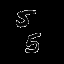

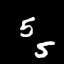

In [40]:
a = data[200, :10].squeeze().numpy()
seq = predict_next10_sequences(data[200, :10], modelA, modelB, time_seq_generation = 10)

visualizeData(a)
visualizeData(seq)